## Statistical model with time-varying parameters

Importerer pakker

In [1]:
import json
import requests
import pickle
import math
import pandas as pd
import os
import numpy as np
import collections
from pathlib import Path
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

import menon_styles
%load_ext autoreload
%autoreload 2

ROOT_DIR = Path(os.environ.get('ROOT_DIR'))
DATA_DIR = ROOT_DIR / 'data'


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('float_format', '{:.2f}'.format)

/Users/kristomi/.pyenv/versions/3.6.4/envs/default/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Menon-farger

In [2]:
menon_styles.menon_styles()

## Read data

In [16]:
from src.make_data import make_all
make_all()

In [3]:
teams = pd.read_pickle(DATA_DIR / 'processed/all_teams.pkl')
teams.head()

team_idx            team  games    win
0         0     Afghanistan    103  29.00
1         1         Albania    314  78.00
2         2         Algeria    482 202.00
3         3  American Samoa     42   4.00
4         4         Andorra    146   5.00

In [4]:
df = (pd
      .read_pickle(DATA_DIR / 'processed'/ 'raw.pkl')
      .merge(right=teams[['team', 'team_idx']], left_on='home_team', right_on='team')
      .drop('team', axis=1)
      .rename(columns={'team_idx': 'home_team_idx'})
      .merge(right=teams[['team', 'team_idx']], left_on='away_team', right_on='team')
      .drop('team', axis=1)
      .rename(columns={'team_idx': 'away_team_idx'})
      .assign(year=lambda df: df.date.dt.year - df.date.dt.year.min())
     )
df.to_pickle('../data/games_idx.pkl')
df.head()

date home_team away_team  home_score  away_score tournament     city  \
0 1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
1 1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
2 1876-03-04  Scotland   England           3           0   Friendly  Glasgow   
3 1878-03-02  Scotland   England           7           2   Friendly  Glasgow   
4 1880-03-13  Scotland   England           5           4   Friendly  Glasgow   

    country  neutral  total_goals  abs_goal_diff  home_win  away_win  \
0  Scotland    False            0              0     False     False   
1  Scotland    False            3              1      True     False   
2  Scotland    False            3              3      True     False   
3  Scotland    False            9              5      True     False   
4  Scotland    False            9              1      True     False   

   home_team_idx  away_team_idx  year  
0            181             64     0  
1            181             64     2  
2            181             64     4  
3            181             64     6  
4            181             64     8

In [5]:
n_teams = len(teams)
n_teams

245

## Model

### Time-varying coefficients on simulated data

Dette er litt vanskelig, jobber meg gradvis fremover

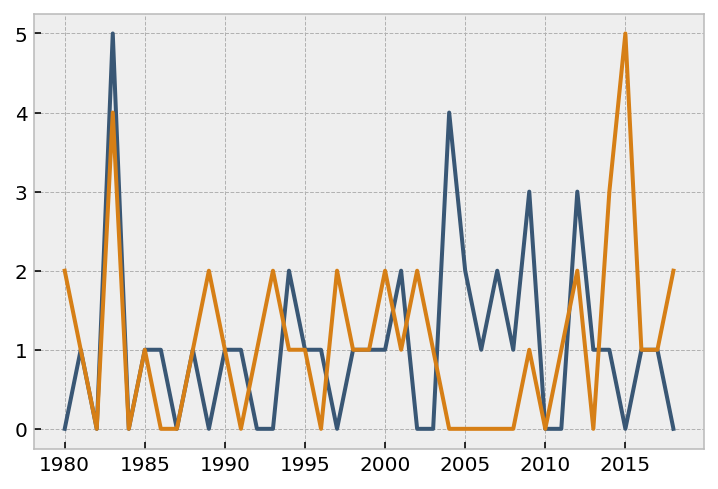

In [110]:
years = np.arange(1980, 2019)
num_years = len(years)
num_teams = 2

np.random.seed(42)
rw = np.cumsum(np.random.normal(scale=.2, size=(num_years, num_teams)), axis=1)
rw = np.exp(rw)
goals = np.array([np.random.poisson(rw[year]) for year in range(num_years)])
plt.plot(years, goals);

In [160]:
sim_df = (pd
          .melt(pd.DataFrame(goals))
          .rename(columns={'variable': 'team_idx', 'value': 'goals'})
          .assign(year = np.tile(np.arange(num_years), num_teams))
          .assign(srt = np.random.random(size=num_years*num_teams))
          .sort_values(by='srt')
          .reset_index(drop=True)
          .drop('srt', axis=1)
         )
#sim_df

In [161]:
np.random.seed(42)
atts_star = np.random.random(size=(num_years, num_teams))
#sim_df.goals.shape
print("Atts star shape:", atts_star.shape)
#atts_star[sim_df.team_idx.values].shape
print(atts_star)

Atts star shape: (39, 2)
[[0.37454012 0.95071431]
 [0.73199394 0.59865848]
 [0.15601864 0.15599452]
 [0.05808361 0.86617615]
 [0.60111501 0.70807258]
 [0.02058449 0.96990985]
 [0.83244264 0.21233911]
 [0.18182497 0.18340451]
 [0.30424224 0.52475643]
 [0.43194502 0.29122914]
 [0.61185289 0.13949386]
 [0.29214465 0.36636184]
 [0.45606998 0.78517596]
 [0.19967378 0.51423444]
 [0.59241457 0.04645041]
 [0.60754485 0.17052412]
 [0.06505159 0.94888554]
 [0.96563203 0.80839735]
 [0.30461377 0.09767211]
 [0.68423303 0.44015249]
 [0.12203823 0.49517691]
 [0.03438852 0.9093204 ]
 [0.25877998 0.66252228]
 [0.31171108 0.52006802]
 [0.54671028 0.18485446]
 [0.96958463 0.77513282]
 [0.93949894 0.89482735]
 [0.59789998 0.92187424]
 [0.0884925  0.19598286]
 [0.04522729 0.32533033]
 [0.38867729 0.27134903]
 [0.82873751 0.35675333]
 [0.28093451 0.54269608]
 [0.14092422 0.80219698]
 [0.07455064 0.98688694]
 [0.77224477 0.19871568]
 [0.00552212 0.81546143]
 [0.70685734 0.72900717]
 [0.77127035 0.07404465]]

In [162]:
print(sim_df.team_idx.values)

[0 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1
 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1
 1 0 1 0]


In [165]:
print(atts_star[sim_df.year.values, sim_df.team_idx.values].shape)
print(sim_df.goals.shape)

(78,)
(78,)


In [166]:
with pm.Model() as simulated_model:
    step_size = pm.Lognormal('step_size', mu=.1, sd=.2, shape=2)
    
    atts_star = pm.GaussianRandomWalk('atts_star', sd=step_size, shape=(num_years, num_teams))
    
    home_theta = tt.exp(atts_star[sim_df.year.values, sim_df.team_idx.values])
    

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=sim_df.goals.values)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/kristomi/.pyenv/versions/3.6.4/envs/default/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atts_star, step_size_log__]
100%|██████████| 1500/1500 [00:19<00:00, 78.87it/s]
The number of effective samples is smaller than 25% for some parameters.


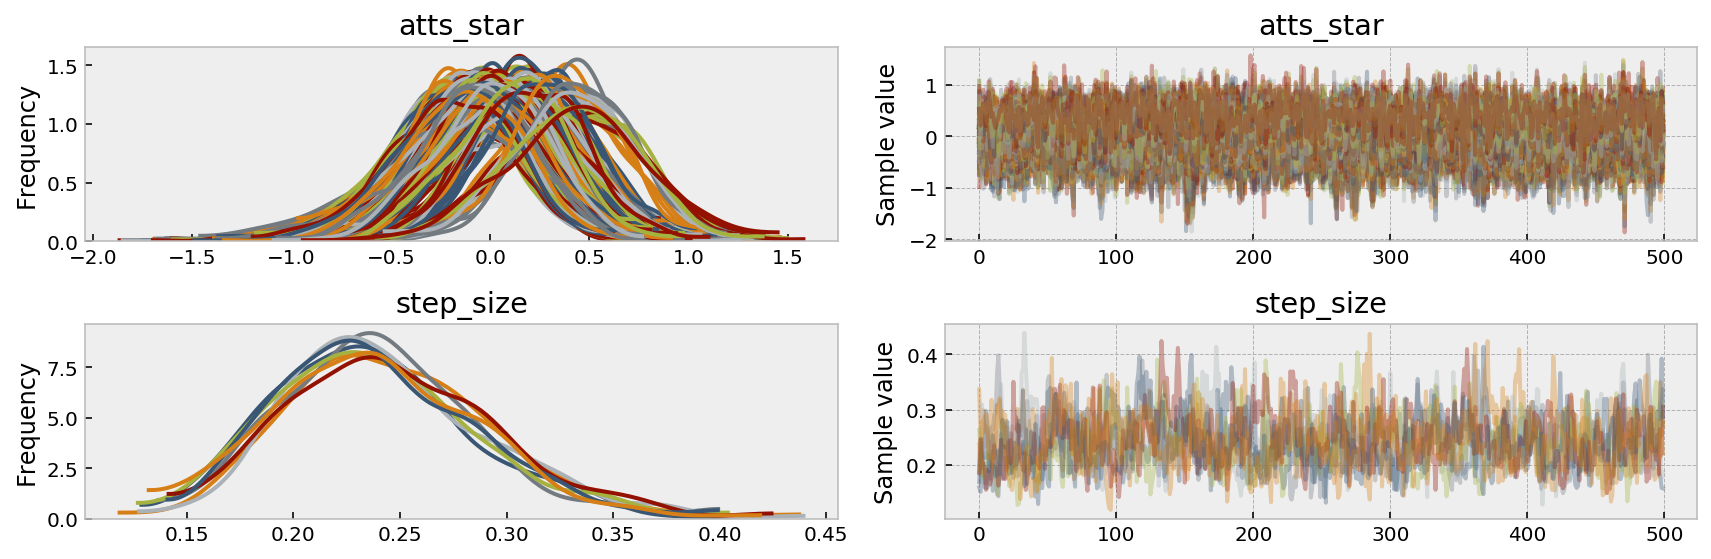

In [167]:
with simulated_model:
    trace = pm.sample(tune=1000, draws=500, ncores=4)
    pm.traceplot(trace);

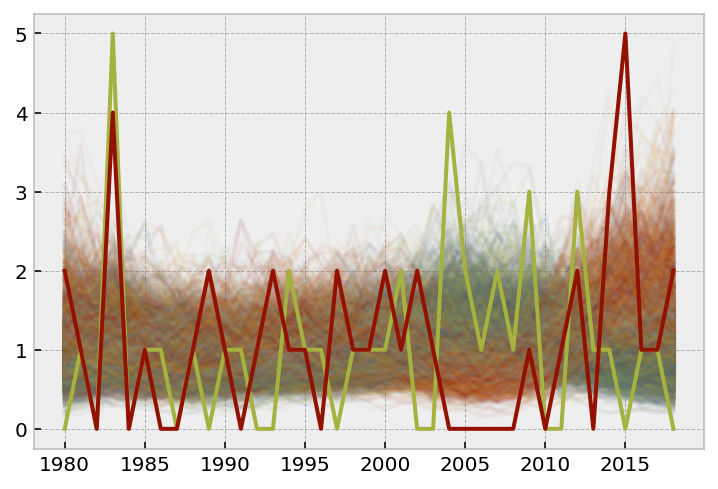

In [169]:
for pars in trace['atts_star']:
    plt.plot(years, np.exp(pars), alpha=.05);
plt.plot(years, goals);

### Trying a gaussian process

In [24]:
with pm.Model() as gp_model:
    years = np.array(list(range(df_tmv.date.dt.year.min(), df_tmv.date.dt.year.max()+1)))[:,None]
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    

    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    atts_star = gp.prior("atts_star", X=years)

    home_theta = tt.exp(atts_star)
    

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=goals)

    trace = pm.sample(1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/kristomi/.pyenv/versions/3.6.4/envs/default/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atts_star_rotated_, η_log__, ℓ_log__]
100%|██████████| 1500/1500 [00:32<00:00, 46.43it/s]
The acceptance probability does not match the target. It is 0.8793564602608235, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some pa

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120057f60>,
      dtype=object)

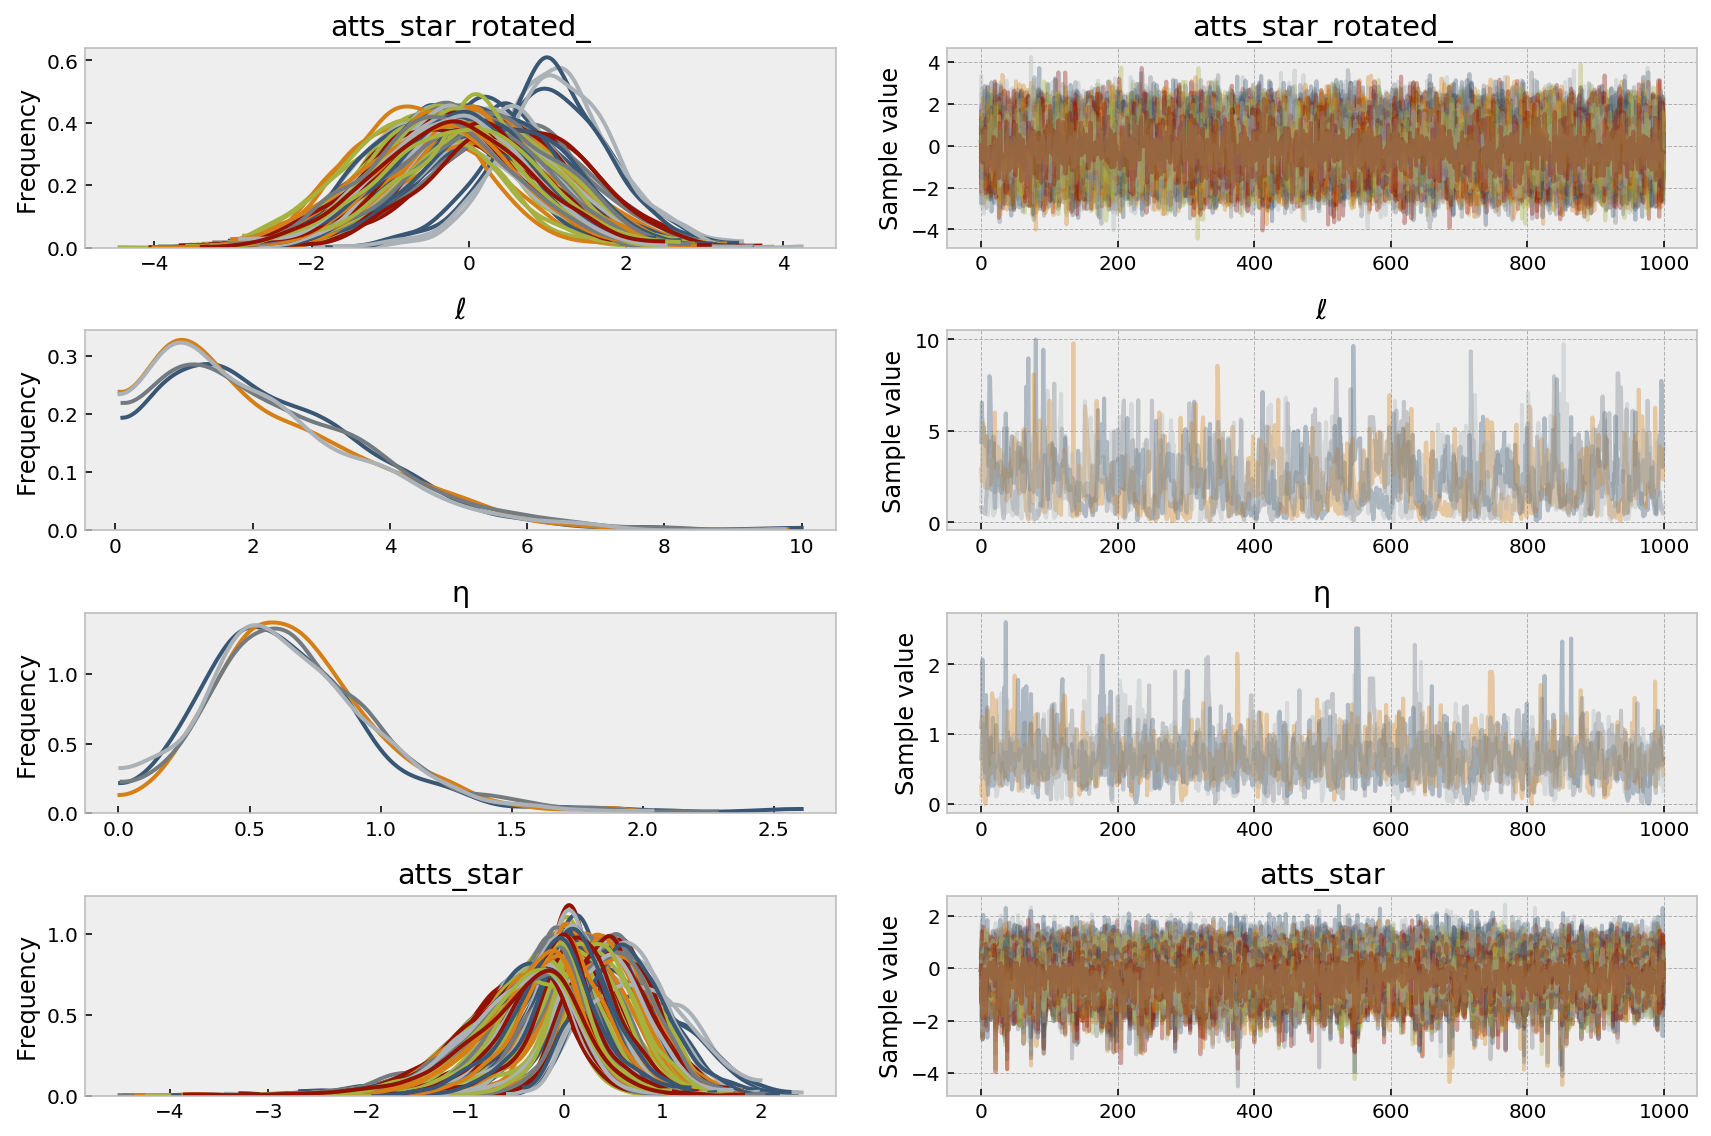

In [28]:
pm.traceplot(trace);

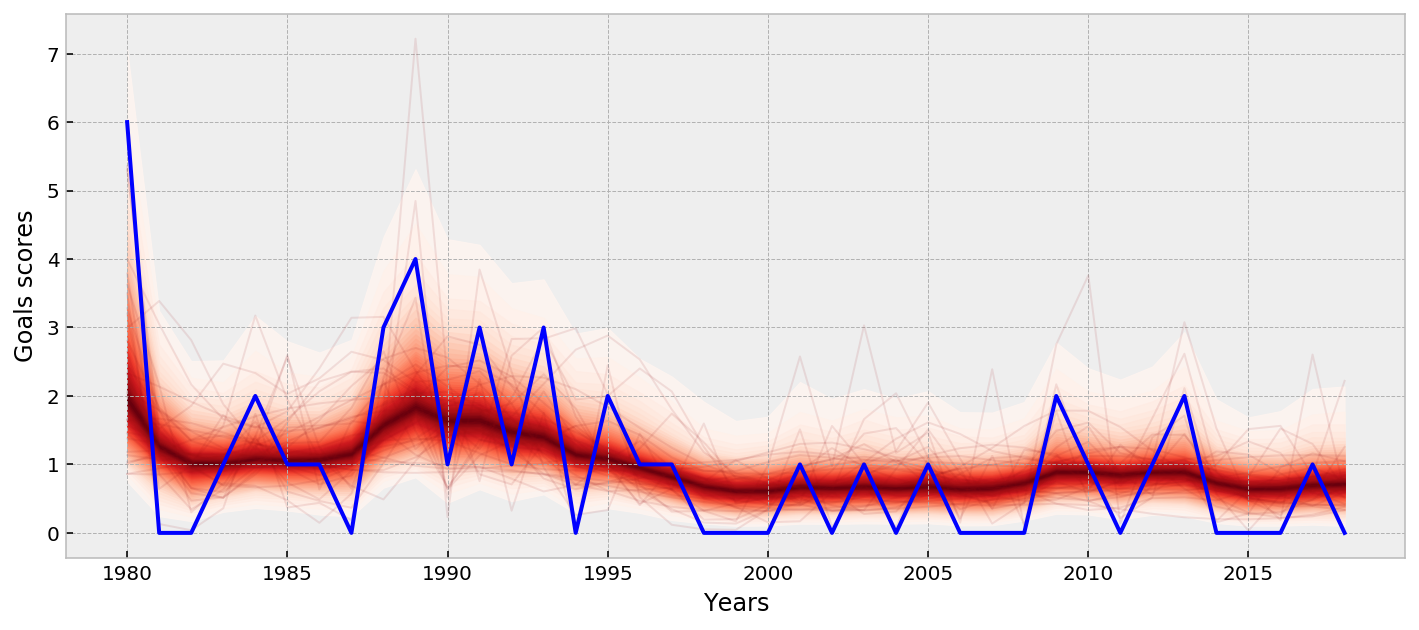

In [27]:
from pymc3.gp.util import plot_gp_dist

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, np.exp(trace["atts_star"]), years);
plt.plot(years, goals, 'b');

plt.xlabel("Years"); plt.ylabel("Goals scored");
#plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

### Random walk on real data - attacks only

In [170]:
included_teams = ['England', 'Brazil', 'South Korea']
df_tmv = (df
          .copy()
          .query("date.dt.year >= 1980")
          .query("home_team in @included_teams")
          .assign(year = lambda df: df.date.dt.year - df.date.dt.year.min())
          .assign(home_team_idx = lambda df: df.home_team.apply(lambda team: included_teams.index(team)))
          .sort_values(by='date', ascending=True)
         )
df_tmv

date    home_team             away_team  home_score  away_score  \
7325  1980-02-06      England               Ireland           2           0   
12210 1980-05-09  South Korea            Luxembourg           2           3   
10829 1980-05-13      England             Argentina           3           1   
12211 1980-05-14  South Korea            Luxembourg           3           0   
915   1980-05-20      England      Northern Ireland           1           1   
17926 1980-06-08       Brazil                Mexico           2           0   
9258  1980-06-15       Brazil                Russia           1           2   
12651 1980-06-24       Brazil                 Chile           2           1   
7086  1980-06-29       Brazil                Poland           1           1   
29874 1980-08-23  South Korea              Malaysia           2           0   
25967 1980-08-25  South Korea             Indonesia           3           0   
28349 1980-08-27  South Korea              Thailand           4           0   
5724  1980-08-27       Brazil               Uruguay           1           0   
27403 1980-08-29  South Korea               Bahrain           5           0   
25968 1980-09-02  South Korea             Indonesia           2           0   
5101  1980-09-10      England                Norway           4           0   
26175 1980-09-24  South Korea  United Arab Emirates           4           1   
23906 1980-09-28  South Korea             Korea DPR           2           1   
18861 1980-10-30       Brazil              Paraguay           6           0   
3222  1980-11-19      England           Switzerland           2           1   
3443  1980-12-21       Brazil           Switzerland           2           0   
1967  1981-01-07       Brazil               Germany           4           1   
12652 1981-03-14       Brazil                 Chile           2           1   
24387 1981-03-22       Brazil               Bolivia           3           1   
6591  1981-03-25      England                 Spain           1           2   
24579 1981-03-29       Brazil             Venezuela           5           0   
29875 1981-04-21  South Korea              Malaysia           2           1   
28350 1981-04-24  South Korea              Thailand           5           1   
10111 1981-04-29      England               Romania           0           0   
8684  1981-05-12      England                Brazil           0           1   
...          ...          ...                   ...         ...         ...   
9092  2016-06-11      England                Russia           1           1   
9756  2016-06-12       Brazil                  Peru           0           1   
598   2016-06-16      England                 Wales           2           1   
11636 2016-06-27      England               Iceland           1           2   
23096 2016-09-01  South Korea                 China           3           2   
12349 2016-09-06       Brazil              Colombia           2           1   
24394 2016-10-06       Brazil               Bolivia           5           0   
16810 2016-10-06  South Korea                 Qatar           3           2   
13186 2016-10-08      England                 Malta           2           0   
11056 2016-11-10       Brazil             Argentina           3           0   
1305  2016-11-11  South Korea                Canada           2           0   
17464 2016-11-11      England              Scotland           3           0   
6596  2016-11-15      England                 Spain           2           2   
27604 2016-11-15  South Korea            Uzbekistan           2           1   
12350 2017-01-26       Brazil              Colombia           1           0   
14754 2017-03-26      England             Lithuania           2           0   
18880 2017-03-28       Brazil              Paraguay           3           0   
30700 2017-03-28  South Korea                 Syria           1           0   
20748 2017-08-31       Brazil               Ecuador           

In [171]:
with pm.Model() as time_varying_model:
    years = list(range(df_tmv.date.dt.year.min(), df_tmv.date.dt.year.max()+1))
    num_years = len(years)

    num_teams = len(included_teams)
    
    sd_mu = pm.Lognormal('sd_mu', mu=.1, sd=.3)
    
    step_size = pm.Lognormal('step_size', mu=sd_mu, sd=.2, shape=num_teams)
    
    atts_star = pm.GaussianRandomWalk('atts_star', sd=step_size, shape=(num_years, num_teams))
    
    home_theta = tt.exp(atts_star[df_tmv.year.values, df_tmv.home_team_idx.values])
    

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=df_tmv.home_score.values)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/kristomi/.pyenv/versions/3.6.4/envs/default/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atts_star, step_size_log__, sd_mu_log__]
100%|██████████| 1500/1500 [00:51<00:00, 29.37it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


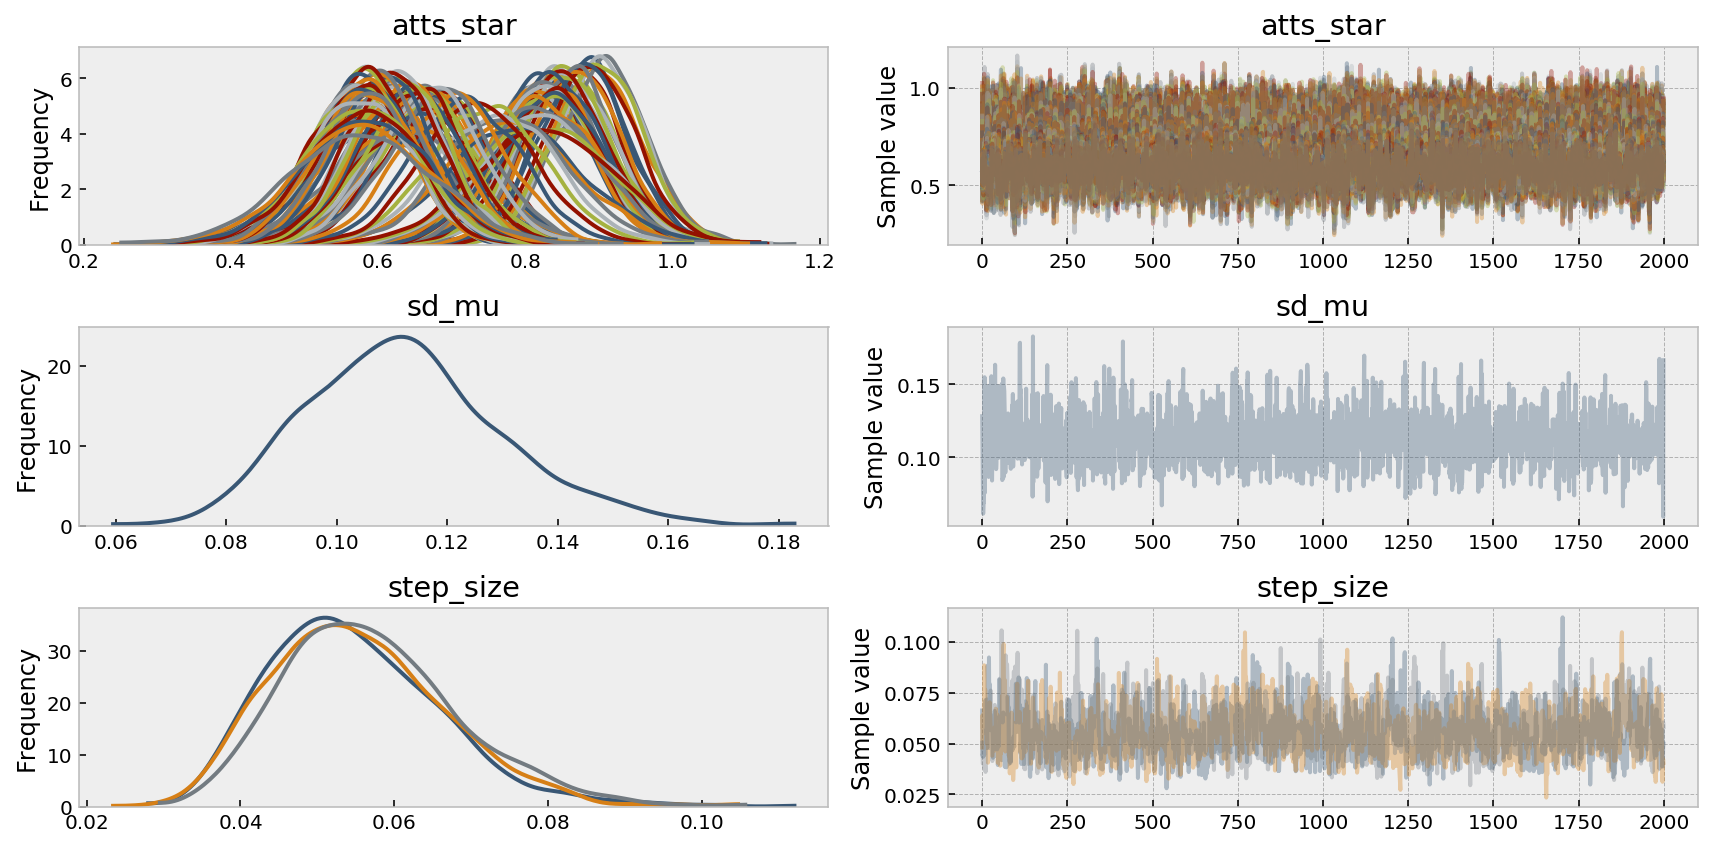

In [31]:
with time_varying_model:
    trace = pm.sample(tune=1000, draws=500, ncores=4)
    pm.traceplot(trace, combined=True);

Teams ranked by attacking strength

In [32]:
(pd
 .DataFrame(trace['atts_star'][-1, :], columns=included_teams)
 .agg(['mean', 'median', 'std'])
 .T
 .sort_values(by='median', ascending=False)
)

mean  median  std
Brazil       0.87    0.88 0.05
South Korea  0.63    0.62 0.05
England      0.59    0.59 0.05

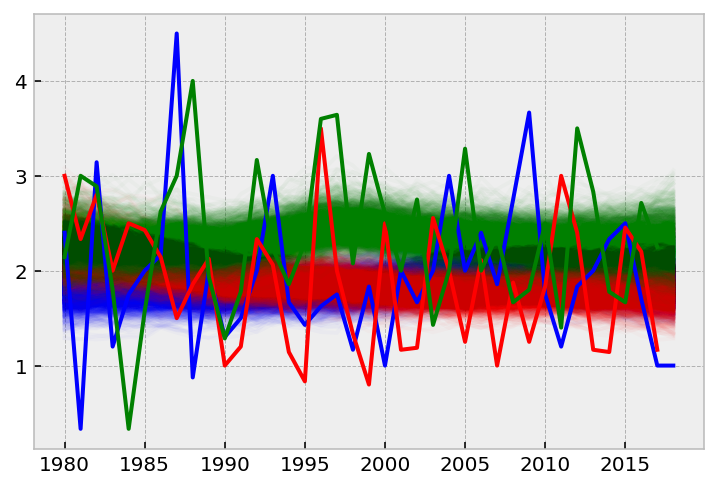

In [33]:
colors = ['b', 'g', 'r']
goals_avg = df_tmv.groupby(['year', 'home_team_idx'])['home_score'].mean().unstack()
for team in df_tmv.home_team_idx.unique():
    for pars in trace['atts_star']:
        plt.plot(years, np.exp(pars[:,team]), colors[team], alpha=.02);
for team in df_tmv.home_team_idx.unique():
    plt.plot(years, goals_avg[team].values, colors[team]);

### Time-varying parameters, also with defense

In [37]:
(df
 .assign(antall=1)
 .groupby('home_team')
 ['antall']
 .sum()
 .nlargest(5)
)

home_team
Brazil       548
Argentina    532
Germany      492
Mexico       491
England      479
Name: antall, dtype: int64

In [175]:
included_teams = ['Argentina', 'Brazil', 'Germany']
df_tmv = (df
          .query("home_team in @included_teams")
          .query("away_team in @included_teams")
          .assign(year = lambda df: df.date.dt.year - df.date.dt.year.min())
          .assign(home_team_idx = lambda df: df.home_team.apply(lambda team: included_teams.index(team)))
          .assign(away_team_idx = lambda df: df.away_team.apply(lambda team: included_teams.index(team)))
          .sort_values(by='date', ascending=True)
         )
df_tmv

date  home_team  away_team  home_score  away_score  \
8749  1914-09-20  Argentina     Brazil           3           0   
8750  1914-09-27  Argentina     Brazil           0           1   
8751  1916-07-10  Argentina     Brazil           1           1   
8752  1917-10-03  Argentina     Brazil           4           2   
11012 1919-05-18     Brazil  Argentina           3           1   
11013 1919-06-01     Brazil  Argentina           3           3   
8753  1920-09-25  Argentina     Brazil           2           0   
8754  1921-10-02  Argentina     Brazil           1           0   
11014 1922-10-15     Brazil  Argentina           2           0   
11015 1922-10-22     Brazil  Argentina           2           1   
8755  1923-11-18  Argentina     Brazil           2           1   
8756  1923-12-02  Argentina     Brazil           0           2   
8757  1923-12-09  Argentina     Brazil           2           0   
8758  1925-12-13  Argentina     Brazil           4           1   
8759  1925-12-25  Argentina     Brazil           2           2   
8760  1937-01-30  Argentina     Brazil           1           0   
8761  1937-02-01  Argentina     Brazil           2           0   
11016 1939-01-15     Brazil  Argentina           1           5   
11017 1939-01-22     Brazil  Argentina           3           2   
11018 1940-02-18     Brazil  Argentina           2           2   
11019 1940-02-25     Brazil  Argentina           0           3   
8762  1940-03-05  Argentina     Brazil           6           1   
8763  1940-03-10  Argentina     Brazil           2           3   
8764  1940-03-17  Argentina     Brazil           5           1   
8765  1942-01-17  Argentina     Brazil           2           1   
8766  1945-02-15  Argentina     Brazil           3           1   
11020 1945-12-16     Brazil  Argentina           3           4   
11021 1945-12-20     Brazil  Argentina           6           2   
11022 1945-12-23     Brazil  Argentina           3           1   
8767  1946-02-10  Argentina     Brazil           2           0   
...          ...        ...        ...         ...         ...   
11050 2004-06-02     Brazil  Argentina           3           1   
8796  2004-07-25  Argentina     Brazil           2           2   
8848  2004-09-08    Germany     Brazil           1           1   
10950 2005-02-09    Germany  Argentina           2           2   
8797  2005-06-08  Argentina     Brazil           3           1   
10951 2005-06-21    Germany  Argentina           2           2   
8849  2005-06-25    Germany     Brazil           2           3   
11051 2005-06-29     Brazil  Argentina           4           1   
10952 2006-06-30    Germany  Argentina           1           1   
8798  2006-09-03  Argentina     Brazil           0           3   
11052 2007-07-15     Brazil  Argentina           3           0   
8799  2009-09-05  Argentina     Brazil           1           3   
10953 2010-03-03    Germany  Argentina           0           1   
1792  2010-07-03  Argentina    Germany           0           4   
8800  2010-11-17  Argentina     Brazil           1           0   
8850  2011-08-10    Germany     Brazil           3           2   
8801  2011-09-14  Argentina     Brazil           0           0   
11053 2011-09-28     Brazil  Argentina           2           0   
11054 2012-06-09     Brazil  Argentina           3           4   
10954 2012-08-15    Germany  Argentina           1           3   
11055 2012-09-19     Brazil  Argentina           2           1   
8802  2012-11-21  Argentina     Brazil           2           1   
1973  2014-07-08     Brazil    Germany           1           7   
10955 2014-07-13    Germany  Argentina           1           0   
10956 2014-09-03    Germany  Argentina           2           4   
8803  2014-10-11  Argentina     Brazil           0           2   
8804  2015-11-13  Argentina     Brazil           1           1   
11056 2016-11-10     Brazil  Argentina           3           0   
8805  2017-06-09  Argentina     Brazil           1  

In [188]:
with pm.Model() as time_varying_model:
    years = list(range(df_tmv.date.dt.year.min(), df_tmv.date.dt.year.max()+1))
    num_years = len(years)

    num_teams = len(included_teams)
        
    step_size = pm.Lognormal('step_size', mu=1, sd=.2, shape=num_teams)
    
    atts_star = pm.GaussianRandomWalk('atts_star', sd=step_size, shape=(num_years, num_teams))
    #defs_star = pm.GaussianRandomWalk('defs_star', sd=step_size, shape=(num_years, num_teams))
    
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star, axis=0))
    #defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star, axis=0))

    
    home = pm.Flat('home')
    intercept = pm.Flat('intercept')
    
    home_theta = pm.Deterministic('home_theta', tt.exp(intercept + home + atts[df_tmv.year.values, df_tmv.home_team_idx.values]))
                       #+ defs_star[df_tmv.year.values, df_tmv.away_team_idx.values])
    away_theta = pm.Deterministic('away_thea', tt.exp(intercept + atts[df_tmv.year.values, df_tmv.away_team_idx.values]))
                        #+ defs_star[df_tmv.year.values, df_tmv.home_team_idx.values])    


    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=df_tmv.home_score.values)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=df_tmv.away_score.values)
    

https://discourse.pymc.io/t/prediction-using-sample-ppc-in-hierarchical-model/116
https://github.com/pymc-devs/pymc3/issues/1001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/kristomi/.pyenv/versions/3.6.4/envs/default/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, home, atts_star, step_size_log__]
100%|██████████| 3000/3000 [12:56<00:00,  3.86it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.7211085504371969, but should be close to 0.8. Try to increase the numbe

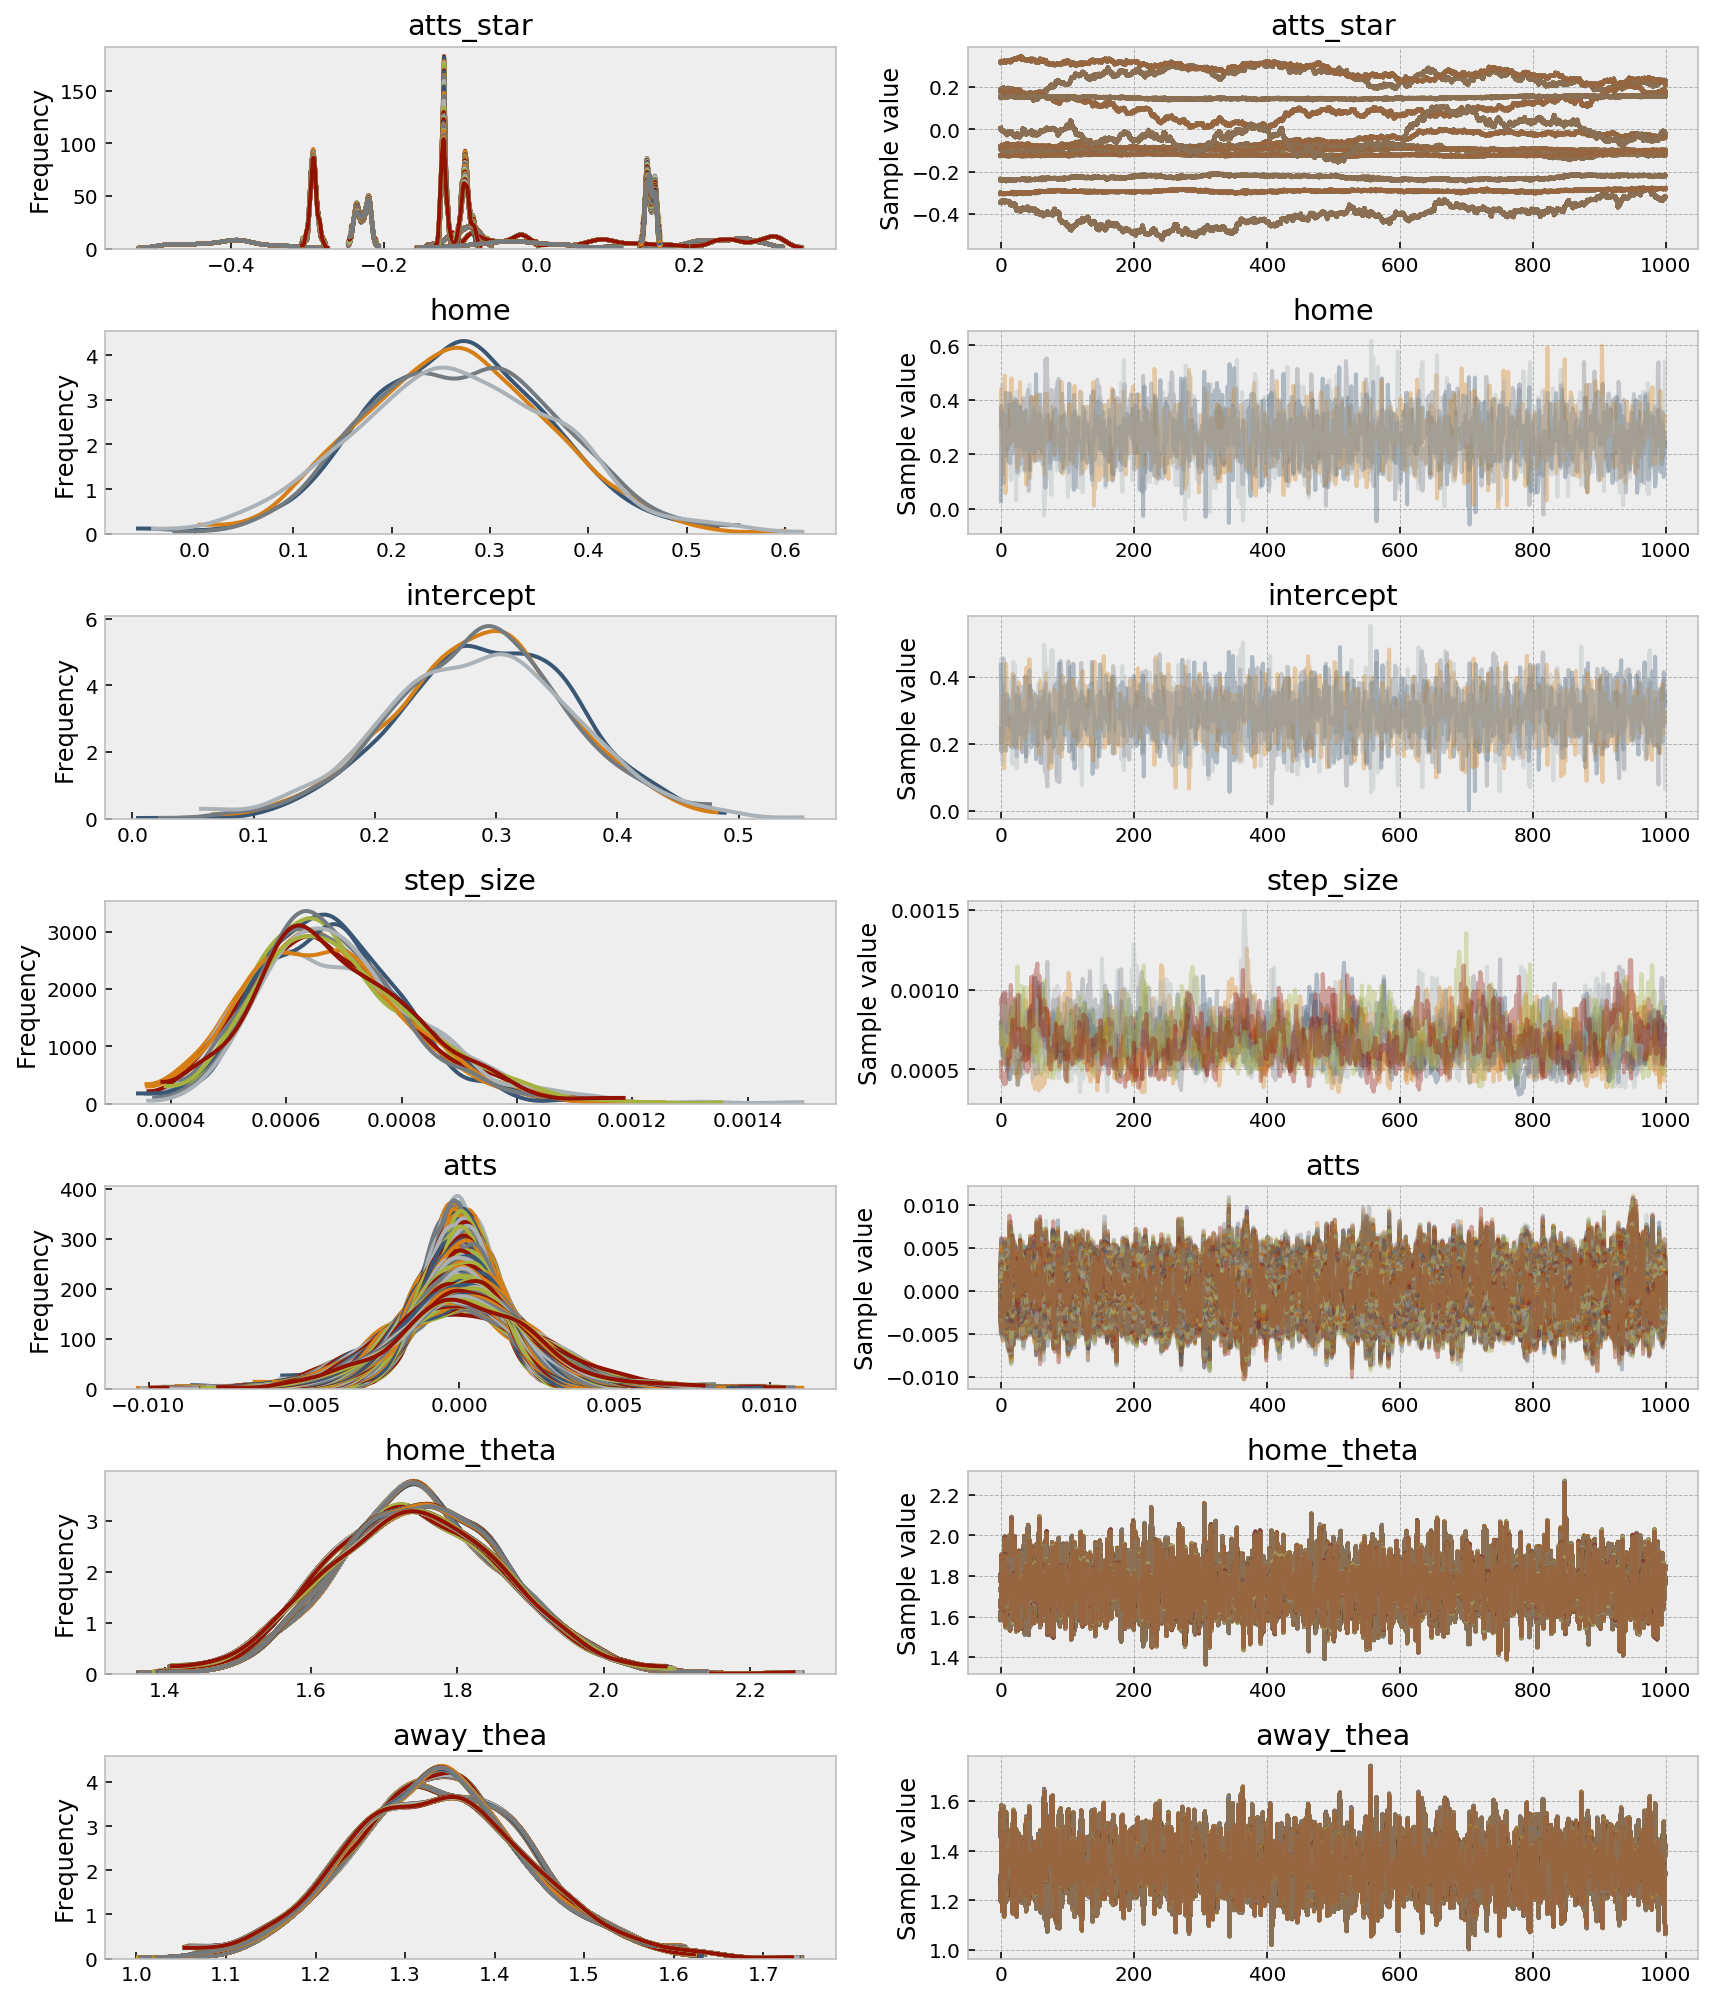

In [191]:
with time_varying_model:
    trace = pm.sample(tune=2000, draws=1000, ncores=4)
    pm.traceplot(trace);

In [193]:
def agg_df(prop='atts'):
    return (pd
             .DataFrame(trace[f'{prop}'][-1, :], columns=included_teams)
             .agg(['mean', 'median', 'std'])
             .T
             .sort_values(by='median', ascending=False)
             .rename(columns=lambda name: f'{prop}-'+name)
            )
pd.concat([agg_df(prop) for prop in ['atts']], axis=1)

atts-mean  atts-median  atts-std
Germany        -0.00         0.00      0.00
Brazil         -0.00        -0.00      0.00
Argentina      -0.00        -0.00      0.00

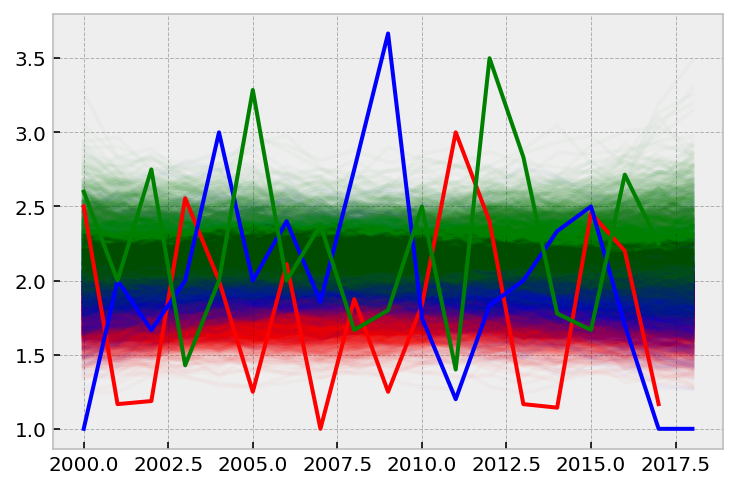

In [209]:
colors = ['b', 'g', 'r']
goals_avg = df_tmv.groupby(['year', 'home_team_idx'])['home_score'].mean().unstack()
for team in df_tmv.home_team_idx.unique():
    for pars in trace['atts_star']:
        plt.plot(years, np.exp(pars[:,team]), colors[team], alpha=.02);
for team in df_tmv.home_team_idx.unique():
    plt.plot(years, goals_avg[team].values, colors[team]);